In [1]:
import cv2
import numpy as np
import tifffile
import bm_examinator
from caiman.base.movies import movie  
import caiman.source_extraction.cnmf.estimates 

def load_tiff_as_array(file_path):
    with tifffile.TiffFile(file_path) as tif:
        array = tif.asarray()  # Загрузка TIFF в виде numpy массива
    return array

In [2]:
# Пути к файлам
tif_file_path = "i:\\Projects\\NOF\\CalciumData\\3_CR_MC\\NOF_H01_1D_CR_MC.tif"
estimate_name = 'i:\\Projects\\NOF\\CalciumData\\4_Estimates\\NOF_H01_1D_gsig4_mincorr0.92_minpnr7_final_final_estimates.pickle'

#### Просто воспроизвести видео

In [ ]:
input_arr = load_tiff_as_array(tif_file_path)

frame_rate = 20
video = movie(input_arr, fr=frame_rate)

video.play(
    gain=1.0,                # Яркость видео
    fr=30,                   # Частота кадров
    magnification=1.0,       # Масштаб
    offset=0,                # Сдвиг
    interpolation=cv2.INTER_LINEAR,
    backend='opencv',        # Используем backend OpenCV
    do_loop=False,           # Не зацикливать видео
    save_movie=False,        # Не сохранять видео
    movie_name='output.avi'  # Имя сохраняемого видео, если save_movie=True
)

#### Воспроизвести видео с контурами из эстимейтов

In [3]:
input_arr = load_tiff_as_array(tif_file_path)
estimate = LoadEstimates(estimate_name, default_fps=20)

i:\Projects\NOF\CalciumData\4_Estimates\NOF_H01_1D_
['i:\\Projects\\NOF\\CalciumData\\4_Estimates\\NOF_H01_1D_timestamp.csv']
No specified time column found, searching for a timeline without name...
Columns with indices [0] can be interpreted as timelines
Assuming column "638331574485491072" with index 0 as a timeline


In [ ]:
# Параметры для воспроизведения видео с контурами
q_max = 99.75      # Максимум для нормализации яркости
q_min = 2          # Минимум для нормализации яркости
thr = 0.2          # Порог для выделения контуров
magnification = 1  # Коэффициент увеличения
frame_range = slice(None, None, None)  # Воспроизведение всех кадров
save_movie = False  # Не сохранять результат
movie_name = 'results_movie_with_estimates.avi'  # Имя файла, если сохранение включено
display = True     # Воспроизвести видео
opencv_codec = 'H264'  # Кодек для сохранения
use_color = False  # Черно-белое видео

# Воспроизведение видео с наложением контуров из estimate
estimate.play_movie(
    imgs=input_arr,       # Ваше видео в виде numpy массива
    q_max=q_max,           # Настройки яркости
    q_min=q_min,
    thr=thr,               # Порог для контуров
    magnification=magnification,  # Коэффициент увеличения
    frame_range=frame_range,  # Диапазон кадров
    save_movie=save_movie,  # Флаг сохранения
    movie_name=movie_name,  # Имя файла, если сохраняется
    display=display,        # Отображать видео
    opencv_codec=opencv_codec,  # Кодек для сохранения
    use_color=use_color     # Черно-белое или цветное видео
)

## Clusterization test

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler

In [46]:
# 1. Загрузка данных
file_path = "c:\\Users\\Plusnin\\YandexDisk\\_Projects\\2024_H_mice\\NOF\\CalciumData\\6_Traces\\NOF_H23_1D_gsig3_mincorr0.9_minpnr20_traces.csv"  # Укажите путь к вашему CSV-файлу
data = pd.read_csv(file_path)

# Первый столбец - временной ряд
time = data.iloc[:, 0]
# Остальные столбцы - активности нейронов
neuron_activities = data.iloc[:, 1:]


In [48]:
neuron_activities

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,784,785
0,49.628317,3.678906,8.812875,-11.251579,-0.105782,10.073885,-25.896927,22.364280,-1.402369,-7.254177,...,-32.796272,-37.702628,-40.056800,161.820170,18.291725,-15.502228,50.243898,51.408567,-23.764663,16.516777
1,46.196676,2.555730,7.371185,-12.025146,-1.460778,10.722956,-26.035936,27.697920,-2.116721,-7.581463,...,-32.799652,-37.702628,-40.056800,154.705089,14.692567,-16.344946,45.354135,46.582174,-24.237012,16.209135
2,44.716200,1.487603,6.005666,-12.763562,-2.743104,8.757890,-26.167635,25.471551,-2.794941,-7.892141,...,-32.802844,-37.702628,-40.056800,143.715908,11.280493,-17.144873,40.743082,59.305013,-13.032651,13.511517
3,41.531481,0.471823,11.623637,-13.468424,-3.956656,15.237924,-26.292408,23.361529,-3.438856,-8.187052,...,-32.805866,-37.702628,-40.056800,143.631710,14.194480,-17.904184,36.394854,62.453443,-14.156273,10.954762
4,46.755682,-0.494176,11.075367,-14.141255,-5.105126,25.517565,-26.410620,22.492602,-4.050201,-8.466999,...,-32.808723,-37.702628,-40.056800,150.331508,10.808299,-18.624939,32.294467,59.344892,-15.211705,15.412234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11843,34.619177,4.053066,11.072063,7.390369,-25.370588,17.282640,-4.510372,8.100220,0.621116,3.758580,...,73.050383,250.584203,-13.566844,28.566913,-24.236583,-13.757980,53.233415,3.066246,-1.918129,-15.520304
11844,38.570849,2.911552,9.511007,5.769691,-13.953578,23.744299,-5.774082,6.897994,-0.195585,2.872441,...,70.969451,247.027623,-14.979526,24.734145,-25.625057,-14.689264,48.173258,0.747387,-1.185211,-16.561102
11845,43.740725,1.825987,8.032430,4.222660,-14.565893,21.048559,-6.971334,5.758589,1.105588,2.031268,...,79.814330,252.288030,-16.316867,21.118839,-26.941356,-15.573259,59.776704,-1.451191,5.361294,-17.547552
11846,40.605044,0.793621,6.631975,2.745924,-15.145368,18.504091,-8.105623,4.678729,9.774978,1.232782,...,73.715071,268.128378,-17.582893,17.708637,-28.189231,-16.412371,54.343584,-3.535728,3.121437,-18.482493


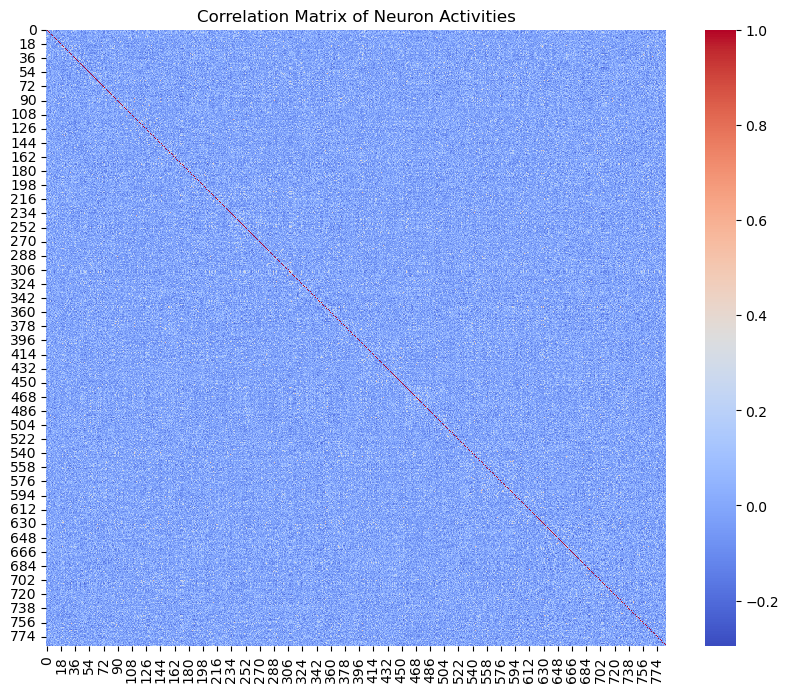

In [47]:
# 2. Построение матрицы корреляций
correlation_matrix = neuron_activities.corr()

# Визуализация матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Neuron Activities")
plt.show()

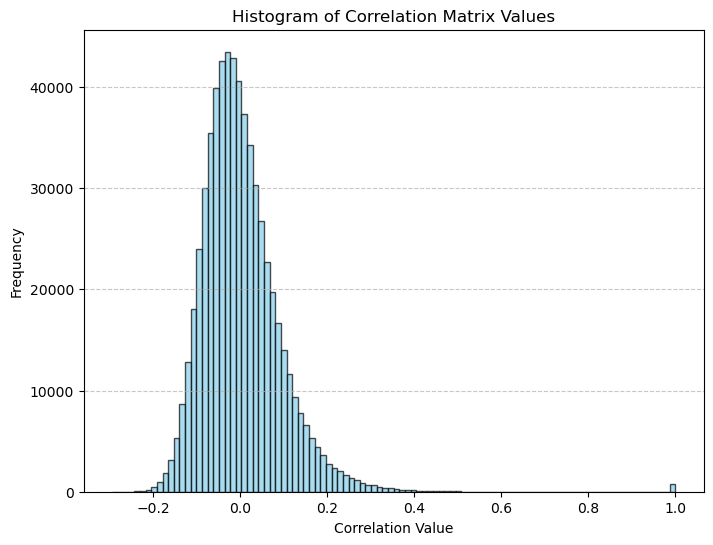

In [49]:
plt.figure(figsize=(8, 6))
plt.hist(correlation_matrix.values.flatten(), bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Correlation Value")
plt.ylabel("Frequency")
plt.title("Histogram of Correlation Matrix Values")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

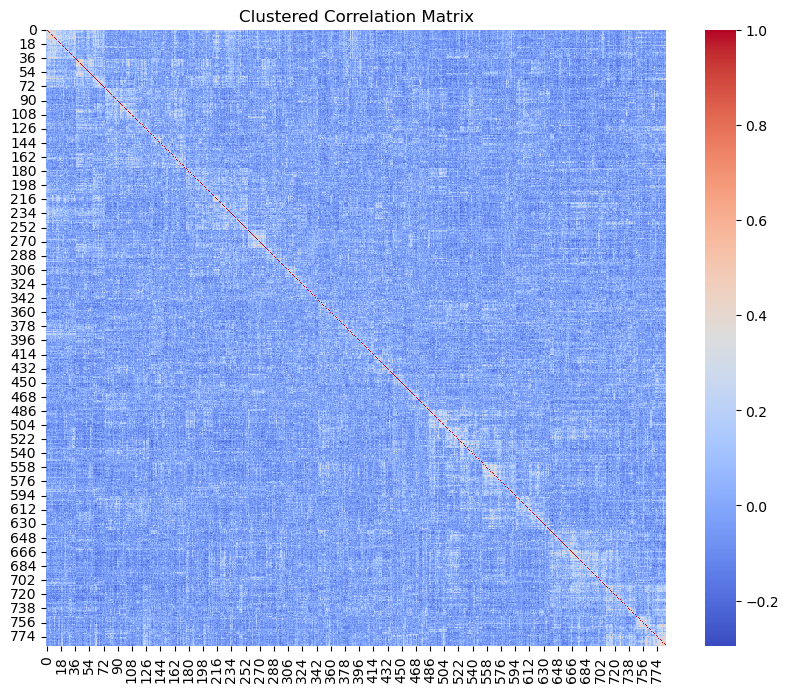

In [50]:
# 3. Иерархическая кластеризация
distance_matrix = 1 - correlation_matrix
linkage = sch.linkage(sch.distance.pdist(distance_matrix), method='ward')
dendro_order = sch.leaves_list(linkage)

# Сортировка матрицы корреляций
sorted_correlation_matrix = correlation_matrix.values[dendro_order, :][:, dendro_order]

# Применение кластерного анализа
clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.5,
    linkage='average',
    metric='precomputed'  # заменён аргумент
)
clusters = clustering.fit_predict(distance_matrix)

# Построение отсортированной матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_matrix, cmap='coolwarm', annot=False, cbar=True)
plt.title('Clustered Correlation Matrix')
plt.show()

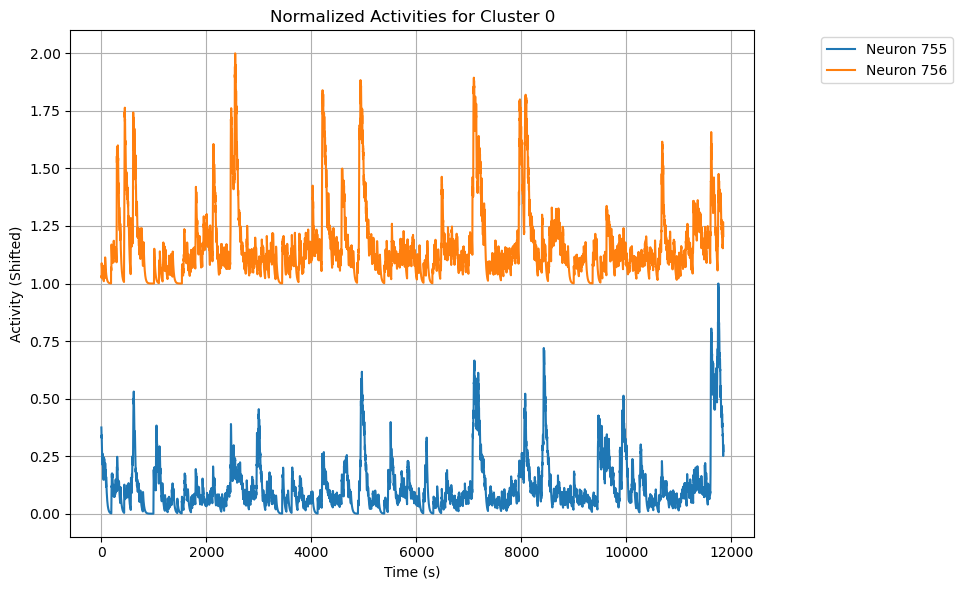

In [51]:
def plot_cluster_activities(cluster_id, cluster_labels, neural_activities):
    # Находим индексы нейронов, принадлежащих к кластеру
    cluster_neurons = np.where(cluster_labels == cluster_id)[0]
    if len(cluster_neurons) == 0:
        print(f"No neurons in cluster {cluster_id}.")
        return
    
    # Извлечение и нормализация активностей
    cluster_activities = neural_activities.iloc[:, cluster_neurons]
    normalized_activities = cluster_activities.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    
    # Сдвиг и построение графиков
    shifted_activities = normalized_activities.add(range(len(cluster_neurons)), axis=1)
    
    plt.figure(figsize=(10, 6))
    
    # Проходим по нейронам в кластере
    for idx, neuron in enumerate(cluster_neurons):
        plt.plot(neural_activities.index, shifted_activities.iloc[:, idx], label=f"Neuron {neuron + 1}")

    plt.title(f"Normalized Activities for Cluster {cluster_id}")
    plt.xlabel("Time (s)")
    plt.ylabel("Activity (Shifted)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Пример вызова
plot_cluster_activities(0, clusters, neuron_activities)


In [62]:
import os
import matplotlib.pyplot as plt
import numpy as np

def save_cluster_activity_plots(cluster_labels, neural_activities, output_dir):
    # Создаем папку для сохранения изображений, если её нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Получаем уникальные идентификаторы кластеров
    unique_clusters = np.unique(cluster_labels)
    
    for cluster_id in unique_clusters:
        # Находим количество нейронов в текущем кластере
        cluster_neurons = np.where(cluster_labels == cluster_id)[0]
        
        # Если в кластере больше одного нейрона, строим график
        if len(cluster_neurons) > 1:
            # Создаем путь для сохранения изображения
            output_path = os.path.join(output_dir, f"cluster_{cluster_id}_activity.png")
            
            # Извлекаем активности нейронов для текущего кластера
            cluster_activities = neural_activities.iloc[:, cluster_neurons]
            
            # Нормализуем активности нейронов в пределах каждого кластера
            normalized_activities = cluster_activities.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
            
            # Сдвигаем активности для лучшего отображения
            shifted_activities = normalized_activities.add(range(len(cluster_neurons)), axis=1)
            
            # Создаем новую фигуру для графика
            fig, ax = plt.subplots(figsize=(10, 6))
            
            # Строим графики для каждого нейрона в кластере
            for idx, neuron in enumerate(cluster_neurons):
                ax.plot(neural_activities.index, shifted_activities.iloc[:, idx], label=f"Neuron {neuron + 1}")
            
            # Добавляем заголовки, подписи и легенду
            ax.set_title(f"Normalized Activities for Cluster {cluster_id}")
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Activity (Shifted)")
            ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
            ax.grid(True)
            fig.tight_layout()
            
            # Сохраняем график в файл
            fig.savefig(output_path, dpi=300)  # Сохраняем с высоким разрешением
            plt.close(fig)  # Закрываем фигуру после сохранения
            print(f"Plot for Cluster {cluster_id} saved to {output_path}")

# Пример вызова
output_directory = "c:\\Users\\Plusnin\\Projects\\Clusters\\"  # Замените на путь к директории для сохранения
save_cluster_activity_plots(clusters, neuron_activities, output_directory)

Plot for Cluster 0 saved to c:\Users\Plusnin\Projects\Clusters\cluster_0_activity.png
Plot for Cluster 1 saved to c:\Users\Plusnin\Projects\Clusters\cluster_1_activity.png
Plot for Cluster 2 saved to c:\Users\Plusnin\Projects\Clusters\cluster_2_activity.png
Plot for Cluster 3 saved to c:\Users\Plusnin\Projects\Clusters\cluster_3_activity.png
Plot for Cluster 4 saved to c:\Users\Plusnin\Projects\Clusters\cluster_4_activity.png
Plot for Cluster 5 saved to c:\Users\Plusnin\Projects\Clusters\cluster_5_activity.png
Plot for Cluster 6 saved to c:\Users\Plusnin\Projects\Clusters\cluster_6_activity.png
Plot for Cluster 7 saved to c:\Users\Plusnin\Projects\Clusters\cluster_7_activity.png
Plot for Cluster 8 saved to c:\Users\Plusnin\Projects\Clusters\cluster_8_activity.png
Plot for Cluster 9 saved to c:\Users\Plusnin\Projects\Clusters\cluster_9_activity.png
Plot for Cluster 10 saved to c:\Users\Plusnin\Projects\Clusters\cluster_10_activity.png
Plot for Cluster 12 saved to c:\Users\Plusnin\Projec